In [ ]:
import pandas as pd

In [ ]:
df_passengers = pd.read_csv("airport.passengers.csv")
df_flights = pd.read_csv("airport.flights.csv")
df_services = pd.read_csv("airport.services.csv")
df_reservations = pd.read_csv("airport.reservations.csv")

In [ ]:
# Fusion
df_merged = df_reservations \
    .merge(df_passengers, on="passenger_id", how="left") \
    .merge(df_flights.drop(columns=["arrival_airport"]), on="flight_id", how="left")

# Matrice passager × airport
user_destination_matrix = pd.crosstab(df_reservations['passenger_id'], df_reservations['arrival_airport'])

# Matrice passager × zone géographique (utilisée dans mat_combined)
user_zone_matrix = pd.crosstab(df_reservations['passenger_id'], df_reservations['destination_zone'])

# Fusion pour récupérer les services associés à chaque passager
df_service_merged = df_reservations[['passenger_id', 'flight_id']] \
    .merge(df_services[['flight_id', 'service_type']], on='flight_id', how='left')

# Matrice passager × type de service
user_service_matrix = pd.crosstab(df_service_merged['passenger_id'], df_service_merged['service_type'])

# Conversion en sparse pour concaténation avec le KNN
user_destination_matrix = user_destination_matrix.astype(pd.SparseDtype("int", 0))
user_service_matrix = user_service_matrix.astype(pd.SparseDtype("int", 0))

In [ ]:
import matplotlib.pyplot as plt

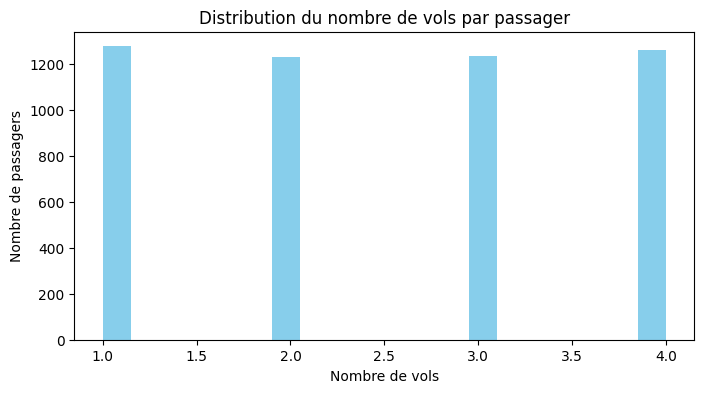

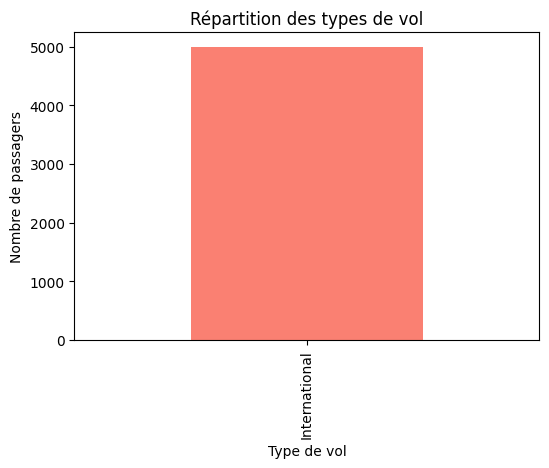

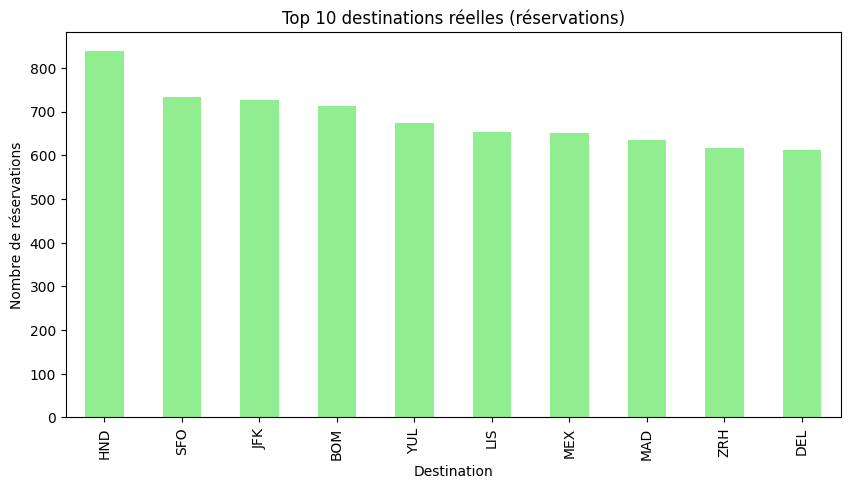

In [ ]:
# Distribution du nombre de vols par passager
vol_counts = df_reservations['passenger_id'].value_counts()

plt.figure(figsize=(8,4))
plt.hist(vol_counts, bins=20, color='skyblue')
plt.title("Distribution du nombre de vols par passager")
plt.xlabel("Nombre de vols")
plt.ylabel("Nombre de passagers")
plt.show()

plt.figure(figsize=(6,4))
df_passengers.drop_duplicates('passenger_id')['flight_type'].value_counts().plot(kind='bar', color='salmon')
plt.title("Répartition des types de vol")
plt.xlabel("Type de vol")
plt.ylabel("Nombre de passagers")
plt.show()

top_destinations = df_reservations['arrival_airport'].value_counts().head(10)

plt.figure(figsize=(10,5))
top_destinations.plot(kind='bar', color='lightgreen')
plt.title("Top 10 destinations réelles (réservations)")
plt.xlabel("Destination")
plt.ylabel("Nombre de réservations")
plt.show()

In [ ]:
# Matrices enrichies : profil passager
user_class_matrix = pd.crosstab(df_reservations['passenger_id'], df_reservations['class'])
user_channel_matrix = pd.crosstab(df_reservations['passenger_id'], df_reservations['booking_channel'])
user_zone_matrix = pd.crosstab(df_reservations['passenger_id'], df_reservations['destination_zone'])
user_frequentflyer_matrix = pd.crosstab(df_reservations['passenger_id'], df_reservations['frequent_flyer'])

# Pour flight_type, on déduplique pour éviter les doublons
user_flighttype_matrix = pd.crosstab(
    df_passengers.drop_duplicates('passenger_id')['passenger_id'],
    df_passengers.drop_duplicates('passenger_id')['flight_type']
)

In [ ]:
# récupérer l’ensemble des passagers communs
common_passengers = set(user_destination_matrix.index) \
    & set(user_service_matrix.index) \
    & set(user_class_matrix.index) \
    & set(user_channel_matrix.index) \
    & set(user_zone_matrix.index) \
    & set(user_frequentflyer_matrix.index) \
    & set(user_flighttype_matrix.index)

common_passengers = sorted(list(common_passengers))  # pour garder un index aligné

In [ ]:
#filtrer toutes les matrices pour n'avoir que les mêmes passagers
user_destination_matrix = user_destination_matrix.loc[common_passengers]
user_service_matrix = user_service_matrix.loc[common_passengers]
user_class_matrix = user_class_matrix.loc[common_passengers]
user_channel_matrix = user_channel_matrix.loc[common_passengers]
user_zone_matrix = user_zone_matrix.loc[common_passengers]
user_frequentflyer_matrix = user_frequentflyer_matrix.loc[common_passengers]
user_flighttype_matrix = user_flighttype_matrix.loc[common_passengers]

In [ ]:
from scipy.sparse import csr_matrix

In [ ]:
mat_dest = csr_matrix(user_destination_matrix.values)
mat_serv = csr_matrix(user_service_matrix.values)
mat_class = csr_matrix(user_class_matrix.values)
mat_channel = csr_matrix(user_channel_matrix.values)
mat_zone = csr_matrix(user_zone_matrix.values)
mat_ff = csr_matrix(user_frequentflyer_matrix.values)
mat_type = csr_matrix(user_flighttype_matrix.values)

In [ ]:
from scipy.sparse import csr_matrix, hstack

In [ ]:
mat_combined = hstack([
    csr_matrix(user_destination_matrix.values),
    csr_matrix(user_service_matrix.values),
    csr_matrix(user_class_matrix.values),
    csr_matrix(user_channel_matrix.values),
    csr_matrix(user_zone_matrix.values),
    csr_matrix(user_frequentflyer_matrix.values),
    csr_matrix(user_flighttype_matrix.values)
])

print(f"Matrice combinée shape : {mat_combined.shape}")

Matrice combinée shape : (3785, 40)


In [ ]:
# Conversion en sparse
user_class_matrix = user_class_matrix.astype(pd.SparseDtype("int", 0))
user_channel_matrix = user_channel_matrix.astype(pd.SparseDtype("int", 0))
user_zone_matrix = user_zone_matrix.astype(pd.SparseDtype("int", 0))
user_frequentflyer_matrix = user_frequentflyer_matrix.astype(pd.SparseDtype("int", 0))
user_flighttype_matrix = user_flighttype_matrix.astype(pd.SparseDtype("int", 0))

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
# Création KNN
knn = NearestNeighbors(metric='cosine', algorithm='brute')  # similarité de profil
knn.fit(mat_combined)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
def recommander_destinations(passenger_id, k=3):
    if passenger_id not in user_destination_matrix.index:
        print(f"Passager {passenger_id} inconnu.")
        return []

    idx = user_destination_matrix.index.get_loc(passenger_id)
    passager_vector = mat_combined.getrow(idx)

    distances, indices = knn.kneighbors(passager_vector, n_neighbors=k+1)

    voisins_ids = [user_destination_matrix.index[i] for i in indices[0][1:]]

    deja_vues = set(user_destination_matrix.loc[passenger_id][user_destination_matrix.loc[passenger_id] == 1].index)

    # Déterminer la zone préférée du passager
    zone_preferee = df_reservations[df_reservations['passenger_id'] == passenger_id]['destination_zone'].mode().iloc[0]

    recommandations = []
    for voisin_id in voisins_ids:
        destinations_voisin = user_destination_matrix.loc[voisin_id]
        nouvelles = destinations_voisin[destinations_voisin == 1].index.difference(deja_vues)

        # Filtrer par zone géographique
        vols_voisin = df_reservations[(df_reservations['passenger_id'] == voisin_id) &
                                      (df_reservations['arrival_airport'].isin(nouvelles))]

        nouvelles_zonées = vols_voisin[vols_voisin['destination_zone'] == zone_preferee]['arrival_airport'].unique()

        recommandations.extend(nouvelles_zonées)

    from collections import Counter
    # Compter les destinations proposées
    dest_counter = Counter(recommandations)

    # Trier par fréquence d'apparition chez les voisins
    recommandations_tries = [dest for dest, _ in dest_counter.most_common(10)]

    return recommandations_tries

In [ ]:
for pid in user_destination_matrix.index.tolist()[:10]:
    recos = recommander_destinations(pid, k=3)
    print(f"{pid} → Recommandations : {recos}")

P00001 → Recommandations : ['ZRH', 'MAD']
P00002 → Recommandations : ['BOM', 'DEL']
P00003 → Recommandations : []
P00004 → Recommandations : []
P00005 → Recommandations : ['LIS', 'ZRH']
P00006 → Recommandations : []
P00007 → Recommandations : ['ZRH', 'MAD', 'LIS']
P00008 → Recommandations : []
P00010 → Recommandations : []
P00011 → Recommandations : ['JFK', 'MEX']


In [ ]:
from tqdm import tqdm
from collections import Counter

In [ ]:
all_recos = []
count_with_recos = 0
total_passagers = len(user_destination_matrix.index)

for pid in tqdm(user_destination_matrix.index):
    recos = recommander_destinations(pid, k=10)
    if recos:
        all_recos.extend(recos)
        count_with_recos += 1

couverture = count_with_recos / total_passagers * 100
print(f"{couverture:.2f}% des passagers ont au moins une recommandation")

100%|██████████| 3785/3785 [03:01<00:00, 20.88it/s]

94.74% des passagers ont au moins une recommandation


In [ ]:
freq = Counter(all_recos)
print("Destinations les plus recommandées :")
for dest, count in freq.most_common(10):
    print(f"{dest} : {count} fois")

Destinations les plus recommandées :
HND : 1108 fois
BKK : 1061 fois
BOM : 1053 fois
ICN : 1048 fois
NRT : 1036 fois
DEL : 1025 fois
PEK : 973 fois
MAD : 455 fois
LIS : 441 fois
AMS : 438 fois


In [ ]:
import matplotlib.pyplot as plt

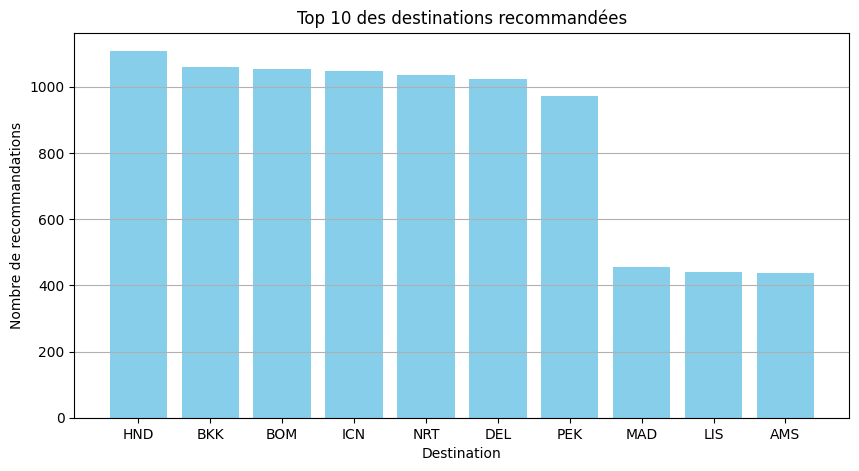

In [ ]:
freq = Counter(all_recos)
top = freq.most_common(10)

if top:
    labels, values = zip(*top)
    plt.figure(figsize=(10, 5))
    plt.bar(labels, values, color="skyblue")
    plt.title("Top 10 des destinations recommandées")
    plt.xlabel("Destination")
    plt.ylabel("Nombre de recommandations")
    plt.grid(axis='y')
    plt.show()
else:
    print("Aucune recommandation générée")

Cela signifie qu’on a masqué une destination par passager (s’il en avait plusieurs), pour tester la capacité de l’algorithme à la recommander.



In [ ]:
def filtrer_recommandations(similar_passenger_ids, target_passenger_id, df_passengers, df_flights):
    """
    Retourne une liste de vols recommandés, en excluant ceux déjà effectués par le passager cible.
    """
    # Vols déjà effectués par le passager cible
    vols_deja_faits = set(df_passengers[df_passengers['passenger_id'] == target_passenger_id]['flight_id'])

    # Vols effectués par les passagers similaires
    vols_similaires = df_passengers[df_passengers['passenger_id'].isin(similar_passenger_ids)]
    vols_similaires_ids = set(vols_similaires['flight_id'])

    # On enlève les vols déjà faits
    vols_recommandes_ids = list(vols_similaires_ids - vols_deja_faits)

    # Détails des vols recommandés
    vols_recommandes = df_flights[df_flights['flight_id'].isin(vols_recommandes_ids)]

    return vols_recommandes


In [ ]:
def recommander_flights_par_id(passenger_id, k=5):
    """
    Recommande des vols à un passager donné, en filtrant les vols qu’il n’a pas encore faits,
    dans sa classe de vol habituelle et sa zone géographique dominante.
    Si besoin, relâche les critères pour garantir des résultats.
    """
    if passenger_id not in user_destination_matrix.index:
        return f"Passager {passenger_id} inconnu."

    # Vérifie le nombre de voyages du passager
    trip_count = df_reservations[df_reservations["passenger_id"] == passenger_id].shape[0]
    if trip_count <= 1:
        return f"Le passager {passenger_id} a effectué trop peu de voyages ({trip_count}) pour générer des recommandations fiables."

    idx = user_destination_matrix.index.get_loc(passenger_id)
    vecteur = mat_combined.getrow(idx)
    distances, indices = knn.kneighbors(vecteur, n_neighbors=k+1)
    voisins_ids = [user_destination_matrix.index[i] for i in indices[0][1:]]

    vols_deja_faits = set(df_reservations[df_reservations['passenger_id'] == passenger_id]['flight_id'])

    zone_preferee = df_reservations[df_reservations['passenger_id'] == passenger_id]['destination_zone'].mode().iloc[0]
    classe_preferee = df_reservations[df_reservations['passenger_id'] == passenger_id]['class'].mode().iloc[0]

    vols_voisins = df_reservations[df_reservations['passenger_id'].isin(voisins_ids)]
    vols_voisins = vols_voisins[~vols_voisins['flight_id'].isin(vols_deja_faits)]

    # Essayer zone + classe
    filtres = (vols_voisins['destination_zone'] == zone_preferee) & (vols_voisins['class'] == classe_preferee)
    vols_filtres = vols_voisins[filtres]

    # Fallback : si trop peu, relâcher à zone uniquement
    if len(vols_filtres) < k:
        vols_filtres = vols_voisins[vols_voisins['destination_zone'] == zone_preferee]

    # Fallback 2 : si toujours trop peu, enlever tous les filtres
    if len(vols_filtres) < k:
        vols_filtres = vols_voisins

    top_vols = vols_filtres['flight_id'].value_counts().head(k).index
    vols_finals = df_flights[df_flights['flight_id'].isin(top_vols)]

    return vols_finals

In [ ]:
print(recommander_flights_par_id("P00002"))

                           _id flight_id flight_number departure_airport  \
137   685abfc00f1531c3d1c718ef   FL00138         AF649               CDG   
202   685abfc00f1531c3d1c71930   FL00203         AF452               CDG   
865   685abfc00f1531c3d1c71bc7   FL00866         AF871               CDG   
939   685abfc00f1531c3d1c71c11   FL00940         AF561               CDG   
1806  685abfc00f1531c3d1c71f74   FL01807         AF693               CDG   

     arrival_airport       departure_time         arrival_time     status  \
137              BKK  2023-10-10T12:00:00  2023-10-10T21:00:00    On Time   
202              ICN  2023-04-27T09:00:00  2023-04-27T11:00:00    Delayed   
865              DEL  2023-08-08T02:00:00  2023-08-08T13:00:00  Cancelled   
939              BKK  2023-11-04T13:00:00  2023-11-05T00:00:00  Cancelled   
1806             BKK  2023-06-28T15:00:00  2023-06-28T23:00:00    Delayed   

      capacity             airline  
137        250     United Airlines  
202   

In [ ]:
def formater_message_recommandation(passenger_id):
    vols = recommander_flights_par_id(passenger_id, k=3)
    if isinstance(vols, str):
        return vols
    destinations = vols['arrival_airport'].unique().tolist()

    zone = df_reservations[df_reservations['passenger_id'] == passenger_id]['destination_zone'].mode().iloc[0]
    classe = df_reservations[df_reservations['passenger_id'] == passenger_id]['class'].mode().iloc[0]

    if not destinations:
        return f"Aucune recommandation trouvée pour {passenger_id}."

    return f"Bonjour {passenger_id}, vous voyagez principalement en {zone} en classe {classe}. Nous vous recommandons : " + ", ".join(destinations) + "."

In [ ]:
print(formater_message_recommandation("P00001"))

Bonjour P00001, vous voyagez principalement en Europe en classe Economy. Nous vous recommandons : MAD, ZRH, AMS.


In [ ]:
def score_recouvrement_destinations(passenger_id, k=10):
    """
    Calcule le pourcentage de destinations communes entre le passager et ses voisins les plus proches.
    """
    if passenger_id not in user_destination_matrix.index:
        return None

    idx = user_destination_matrix.index.get_loc(passenger_id)
    vecteur = mat_combined.getrow(idx)
    distances, indices = knn.kneighbors(vecteur, n_neighbors=k+1)
    voisins_ids = [user_destination_matrix.index[i] for i in indices[0][1:]]

    dest_p = set(user_destination_matrix.loc[passenger_id][user_destination_matrix.loc[passenger_id] == 1].index)
    dest_voisins = set()

    for voisin in voisins_ids:
        dest_v = user_destination_matrix.loc[voisin][user_destination_matrix.loc[voisin] == 1].index
        dest_voisins.update(dest_v)

    if not dest_voisins:
        return 0.0

    communs = dest_p.intersection(dest_voisins)
    return len(communs) / len(dest_p) * 100 if dest_p else 0

In [ ]:
scores = []

for pid in tqdm(user_destination_matrix.index[:100]):
    score = score_recouvrement_destinations(pid, k=10)
    if score is not None:
        scores.append(score)

import numpy as np
print(f"Score moyen de recouvrement : {np.mean(scores):.2f}% sur {len(scores)} passagers")

100%|██████████| 100/100 [00:01<00:00, 50.90it/s]

Score moyen de recouvrement : 97.67% sur 100 passagers


In [ ]:
def afficher_voisins_proches(passenger_id, k=5):
    """
    Affiche les k passagers les plus proches du passager donné selon KNN,
    avec quelques informations comparatives.
    """
    if passenger_id not in user_destination_matrix.index:
        print(f"{passenger_id} inconnu.")
        return

    idx = user_destination_matrix.index.get_loc(passenger_id)
    vecteur = mat_combined.getrow(idx)
    distances, indices = knn.kneighbors(vecteur, n_neighbors=k+1)

    voisins_ids = [user_destination_matrix.index[i] for i in indices[0][1:]]

    # Extraire le profil du passager + de ses voisins
    profils = df_reservations[df_reservations['passenger_id'].isin([passenger_id] + voisins_ids)]

    # Agréger (zone, classe, fidélité) par passager
    resume = profils.groupby('passenger_id').agg({
        'destination_zone': lambda x: x.mode().iloc[0],
        'class': lambda x: x.mode().iloc[0],
        'frequent_flyer': lambda x: x.mode().iloc[0],
        'flight_id': 'nunique'
    }).rename(columns={
        'destination_zone': 'Zone préférée',
        'class': 'Classe préférée',
        'frequent_flyer': 'Fidélité',
        'flight_id': 'Nb vols'
    })

    resume.reset_index(inplace=True)
    resume['Profil'] = resume['passenger_id'].apply(
        lambda x: 'Passager cible' if x == passenger_id else 'Voisin'
    )

    import matplotlib.pyplot as plt
    import seaborn as sns

    # Affichage en tableau
    display(resume.sort_values('Profil', ascending=False).set_index('passenger_id'))

    # visualisation
    plt.figure(figsize=(8, 4))
    sns.countplot(data=resume, x='Zone préférée', hue='Profil')
    plt.title(f"Zones préférées – {passenger_id} vs voisins")
    plt.show()

    plt.figure(figsize=(8, 4))
    sns.countplot(data=resume, x='Classe préférée', hue='Profil')
    plt.title(f"Classe – {passenger_id} vs voisins")
    plt.show()

    # Récupérer les destinations visitées par pays
    destinations_pays = df_reservations[
        df_reservations['passenger_id'].isin([passenger_id] + voisins_ids)
    ][['passenger_id', 'destination_country']]

    plt.figure(figsize=(10, 4))
    sns.countplot(
        data=destinations_pays,
        x='destination_country',
        hue='passenger_id',
        order=destinations_pays['destination_country'].value_counts().index
    )
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Pays visités – {passenger_id} vs voisins")
    plt.tight_layout()
    plt.show()

In [ ]:
from ipywidgets import interact, Dropdown

# Liste déroulante des passagers
passager_dropdown = Dropdown(
    options=sorted(user_destination_matrix.index),
    description='Passager:',
    value='P00001',
    style={'description_width': 'initial'},
    layout={'width': '50%'}
)

@interact(passenger_id=passager_dropdown)
def afficher_profil_interactif(passenger_id):
    afficher_voisins_proches(passenger_id, k=5)

interactive(children=(Dropdown(description='Passager:', layout=Layout(width='50%'), options=('P00001', 'P00002…

/tmp/ipython-input-57-1066360032.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(labels), y=list(values), palette='Blues_d')


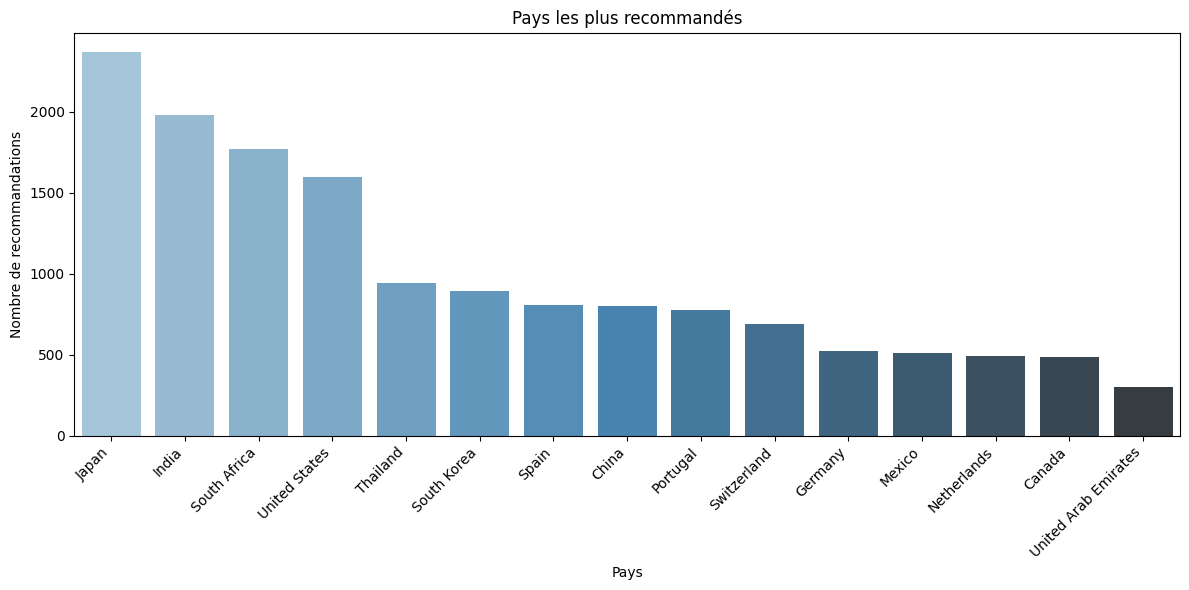

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

reco_pays = []

for pid in user_destination_matrix.index[:500]:  # augmente si tu veux
    vols = recommander_flights_par_id(pid, k=5)
    if isinstance(vols, pd.DataFrame) and not vols.empty:
        flight_ids = vols['flight_id'].tolist()
        pays = df_reservations[df_reservations['flight_id'].isin(flight_ids)]['destination_country'].dropna().tolist()
        reco_pays.extend(pays)

# Compter les pays recommandés (tous)
pays_counts = Counter(reco_pays)
labels, values = zip(*pays_counts.items())

# Trier par nombre de recos décroissant
labels, values = zip(*sorted(zip(labels, values), key=lambda x: x[1], reverse=True))

# Graphique
plt.figure(figsize=(12, 6))
sns.barplot(x=list(labels), y=list(values), palette='Blues_d')
plt.title("Pays les plus recommandés")
plt.ylabel("Nombre de recommandations")
plt.xlabel("Pays")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Imports nécessaires (à faire une seule fois si déjà faits)
from IPython.display import display, clear_output
import ipywidgets as widgets
import seaborn as sns
import matplotlib.pyplot as plt

# Fonction de suggestion de destinations (adaptée à ton dataset)
def suggest_personalized_destinations(passenger_id, show_graph=True, export_csv=False):
    # Vérifie que le passager existe et a au moins 2 vols
    target_profile = df_reservations[df_reservations["passenger_id"] == passenger_id]
    if target_profile.shape[0] <= 1:
        print(f"Le passager {passenger_id} a effectué trop peu de voyages ({target_profile.shape[0]}) pour générer des suggestions fiables.")
        return pd.DataFrame()

    # Extraire ses préférences principales
    try:
        preferred_zone = target_profile["destination_zone"].mode().iloc[0]
        preferred_class = target_profile["class"].mode().iloc[0]
        preferred_airline = target_profile["airline"].mode().iloc[0]
    except IndexError:
        print(f"Données insuffisantes pour le passager {passenger_id}")
        return pd.DataFrame()

    # Passagers similaires sur zone + classe + compagnie
    similar_ids = df_reservations[
        (df_reservations["destination_zone"] == preferred_zone) &
        (df_reservations["class"] == preferred_class) &
        (df_reservations["airline"] == preferred_airline) &
        (df_reservations["passenger_id"] != passenger_id)
    ]["passenger_id"].unique()

    # Leurs vols
    similar_flights = df_reservations[df_reservations["passenger_id"].isin(similar_ids)]
    flight_options = similar_flights[["flight_id", "arrival_airport", "destination_country"]].drop_duplicates()

    # Retirer les vols déjà pris par le passager
    taken_flights = target_profile["flight_id"].unique()
    personalized_recos = flight_options[~flight_options["flight_id"].isin(taken_flights)].reset_index(drop=True)

    # Affichage
    if personalized_recos.empty:
        print(f"Aucune nouvelle destination recommandée pour {passenger_id}.")
    else:
        print(f"Destinations personnalisées pour {passenger_id} :")
        display(personalized_recos)

        if show_graph:
            plt.figure(figsize=(10, 5))
            sns.countplot(data=personalized_recos, x="destination_country",
                          order=personalized_recos["destination_country"].value_counts().index)
            plt.title("Pays recommandés")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

        if export_csv:
            filename = f"recommandations_{passenger_id}.csv"
            personalized_recos.to_csv(filename, index=False)
            print(f"Fichier exporté : {filename}")

    return personalized_recos

In [ ]:
# Interface interactive pour tester la fonction
passenger_input = widgets.Text(
    value='P00001',
    placeholder='Entrez un passenger_id',
    description='Passager :',
    disabled=False
)

button = widgets.Button(description="Suggérer")
output = widgets.Output()

def on_suggest_clicked(b):
    with output:
        clear_output()
        pid = passenger_input.value.strip()
        suggest_personalized_destinations(pid)

button.on_click(on_suggest_clicked)

# Affichage de l'interface
display(passenger_input, button, output)

Text(value='P00001', description='Passager :', placeholder='Entrez un passenger_id')

Button(description='Suggérer', style=ButtonStyle())

Output()